# Trial 3 - Combined Energy and Bandwidth Metrics

Directly below is the physical craft parameters.
Secondly is the scenario setup (# of users and distribution).
The remainder are different trajectories, with their metrics graphed.


Some constraints we'll apply for this inquiry:
- Each trajectory MUST be within the 2 km radius of the origin (horizontally)
- Each trajectory MUST be between 1 km and 10 km altitude
  - Lower is, of course, better (higher density implies less power, as well as less path loss distance)
    so the constant altitude trajectories will be on that floor.
- Each trajectory MUST be perpetual with an mSoC of 40% (after our 6 hour margin)
  - This favors tighter trajectories, up to the mSoC limit from power use
- Trajectories are hand adjusted until we run into the mSoC limit, 
  and subsequently adjusted to be nearly an integer divisor of 24 hours
  
Metrics we'll get out of this:
- Throughput: min user, avg user
  
## Important Notes
- The payload power draw is probably overstated
- The aircraft mass is probably understated (TODO finish understanding the relevant Oettershagen paper)
- The battery energy density is moderately to vastly beyond that available in 2020
  (using hypothetical SionPower/Licerion advertised 650 Wh/kg cells vs 265 Wh/kg for Li-Ion [citation needed])
- Total throughput (IP layer, all UEs) is around half the calculated value (Shannon formula)
  - We've found that TCP streams, if exceeding some value, catastrophically decrease in throughput with the default NS3 config.
    UDP streams will still saturate the network.
- We are NOT (TODO should we?) optimizing the angle-of-attack for now, leaving at 5° above flow.
  - This is most likely not ideal for ascending/descending segments, but should be reasonable for horizontal with
    the airfoils we are using.

In [566]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

if 'thesis.Aircraft' in sys.modules: del sys.modules['thesis.Aircraft']
from thesis.Aircraft import Aircraft

if 'thesis.Flight' in sys.modules: del sys.modules['thesis.Flight']
from thesis.Flight import Flight

# Just some figuring out how heavy we are
# https://www.doubleradius.com/site/stores/baicells/baicells-nova-233-gen-2-enodeb-outdoor-base-station-datasheet.pdf
# Unsure how massive antenna are, guessing 1 kg
# Potentially unreliable sources say that the Starlink terminal is about 12 Ibs (https://www.reddit.com/r/Starlink/comments/jqck07/how_much_does_dishy_weigh/)
m_payload = 4.4 + 1 + 6  # kg
# Starlink power figure https://arstechnica.com/information-technology/2020/11/spacex-starlink-beta-tester-takes-user-terminal-into-forest-gets-120mbps/
# This figure may be overstated as it is for that users "whole system" (router, other equipment included?)
# Others say 50-100 W https://www.reddit.com/r/Starlink/comments/kf8ajt/power_consumption_of_starlink/
# We compromise here with 80
P_payload = 45 + 80       # W

# Main contributor to performance, both from an efficiency and solar area perspective
# Estimating 8-24 m is sufficient (summer vs winter at 45 N latitude)
wingSpan = 8 # m
wingChord = 0.5 # m
wingArea = wingSpan * wingChord # m^2
solarFill = 0.85 # % of wing surface with solar PV
solarArea = wingArea * solarFill # Solar panel area m^2

P_solar_cap = 1600 # Maximum solar power in (W)
P_prop = 600       # Maximum propellor power (W)

# Mostly taken from Oettershagen2017Design
m_struct = 6 # Guessing

# Absolute guesswork (mass per wing area for structure)
# Kevlar is like 1.4 g/cc
# "Light aircraft" might have 0.015 to 0.025 in (0.38-0.64 mm) thick wing skins [cite wp]
# density * thickness * 2 surfaces * area
# Also would have mass for airfoil pieces and lateral structure, so erring on the higher side for thickness to compensate
thickness = 0.6 # mm
m_wings = 1.4 * thickness * 2 * wingArea
#m_wings = 0.05 * wingSpan * wingChord * 2

# TODO for final version take data points from Oettershaggen paper and HAPSMobile to interpolate/verify these values

m_prop = 0.0011 * P_prop
m_solar = 0.59 * solarArea
m_mppt = 0.422 * 0.422e-3 * P_solar_cap
m_av = 1.22
bat_Wh_cap = 4000
# From Oettershagen
#m_bat = bat_Wh_cap / 251
# From hypothetical Licerion/Sionpower Lithium-metal cells
m_bat = bat_Wh_cap / 650

mass = m_struct + m_wings + m_prop + m_solar + m_mppt + m_av + m_payload + m_bat
print('Mass is %.2f kg (%.2f kg wings)' % (mass, m_wings))

# From NS3 defaults
radioParams = {
    'xmitPower': 30, # dBm
    'B': 180e3 * 25, # 25 180kHz RBs = 4.5 MHz
    'N0': -174       # See lte-spectrum-value-helper.cc kT_dBm_Hz
}

craft = Aircraft(mass = mass, wingSpan = wingSpan, e0 = 0.92, chord = wingChord)

print('For runner.py')
print('='*80)
print('mass, wingSpan, e0, chord, bat_Wh_cap = %.2f, %.2f, %.2f, %.2f, %.2f' % (mass, wingSpan, 0.92, wingChord, bat_Wh_cap))

Mass is 51.90 kg (20.16 kg wings)
For runner.py
mass, wingSpan, e0, chord, bat_Wh_cap = 51.90, 24.00, 0.92, 0.50, 4000.00


In [572]:
if 'thesis.EvalHelper' in sys.modules: del sys.modules['thesis.EvalHelper']
if 'thesis.Scenario' in sys.modules: del sys.modules['thesis.Scenario']

from thesis.EvalHelper import Judge
from thesis.Scenario import Scenario

scene = Scenario()
scene.addRandomGroundUsersUniformCircular(2, r = 5000)

judge = Judge(scene, craft)

scene.render(size=50000)

Graphics3d Object

 Flight Info
1212 Second cycles, for 71 cycles with 313 left over
2020-07-01 00:20:00-04:00
altitude min=1000 mean=1000 max=1000


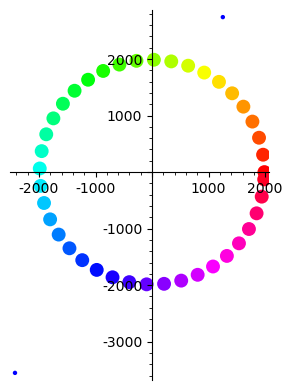



 Power info
2020-12-03 08:00:00-05:00
mSoc = -13.07%




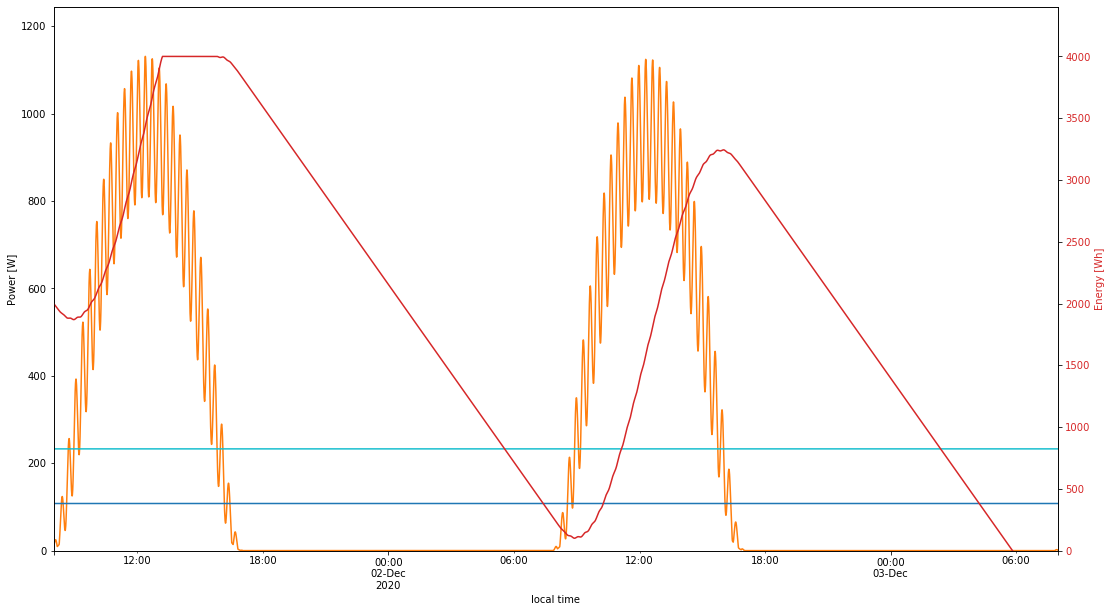

In [584]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import CircleTrajectory
trajectory = CircleTrajectory((0, 0, 1000), 1987.8)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-12-01T08', end = '2020-12-03T08')

 Throughput (estimated) and altitude
2020-07-03 08:00:00-04:00


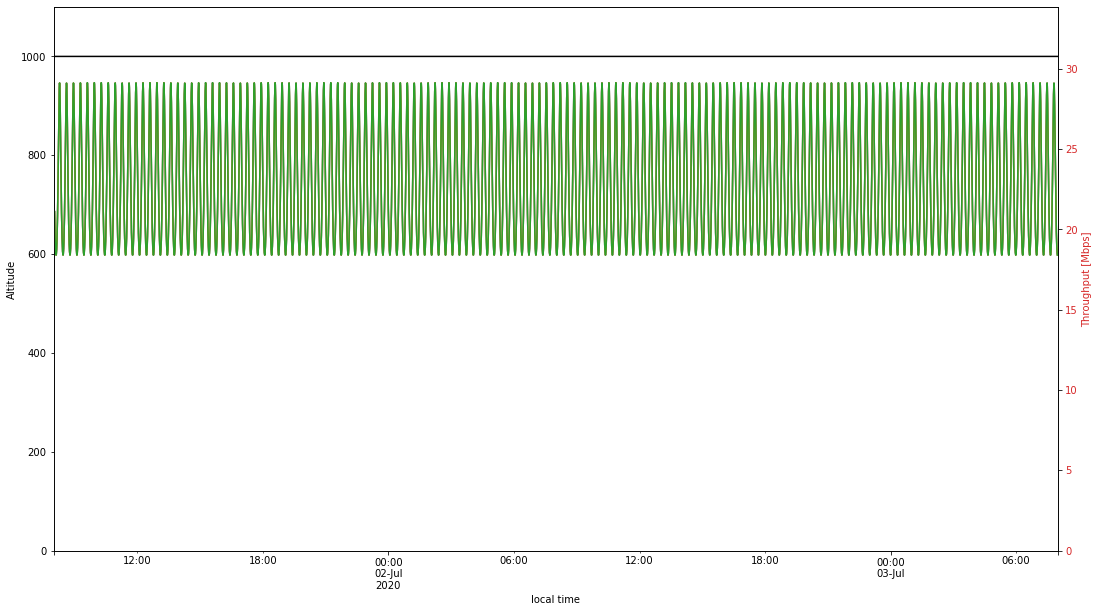

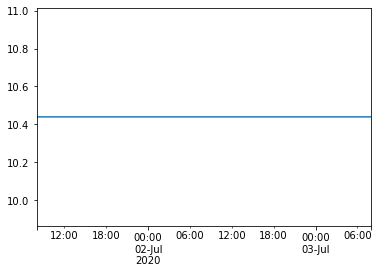

In [415]:
judge.displayFlightAltitudeThroughputInfo(flight)

2.276295

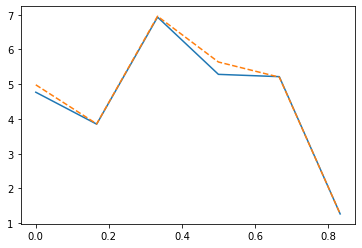

In [576]:
serverStats, clientStats = judge.runNS3Simulation(flight)
index = [float(i * 10 / 60) for i in range(len(serverStats) - 1)]
pd.Series(np.array(serverStats[1:]).sum(1) / 1e6, index = index).plot()
pd.Series(np.array(clientStats[1:]).sum(1) / 1e6, index = index).plot(linestyle='dashed')
np.array(serverStats[1:]).mean() / 1e6

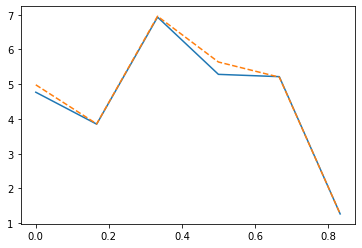

In [583]:
index = [float(i * 10 / 60) for i in range(len(serverStats) - 1)]
pd.Series(np.array(serverStats[1:]).sum(1) / 1e6, index = index).plot()
pd.Series(np.array(clientStats[1:]).sum(1) / 1e6, index = index).plot(linestyle='dashed')
pd.DataFrame(serverStats[1:], index=index).to_csv('test.csv')

 Flight Info
918 Second cycles, for 94 cycles with 58 left over
2020-07-01 00:15:00-04:00
altitude min=1000 mean=1000 max=1000


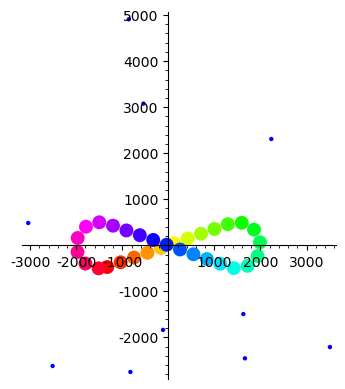



 Power info
2020-12-03 08:00:00-05:00
mSoc = -8.14%




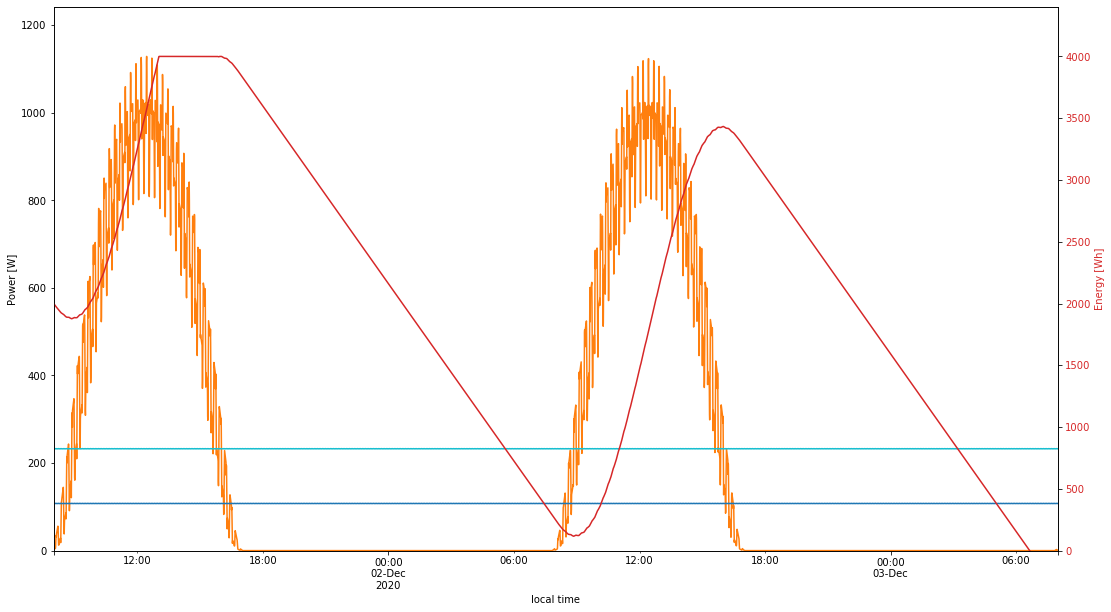

In [553]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import BowtieTrajectory
trajectory = BowtieTrajectory((0, 0, 1000), lobeRadius = 500, lobeCenterDistance = 1494.4)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-12-01T08', end = '2020-12-03T08')

 Throughput (estimated) and altitude
2020-07-03 08:00:00-04:00


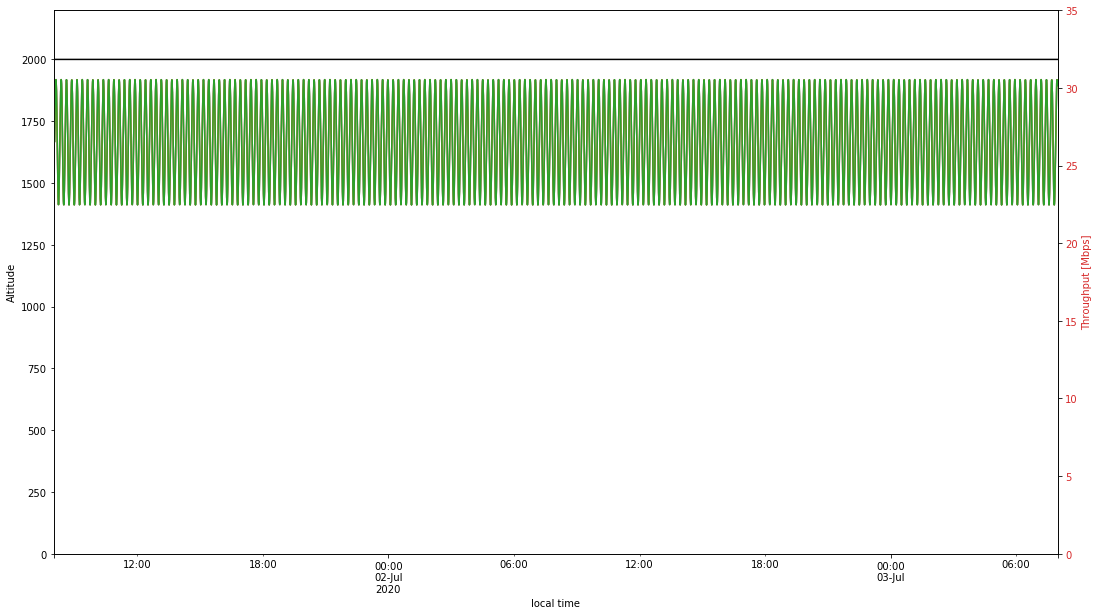

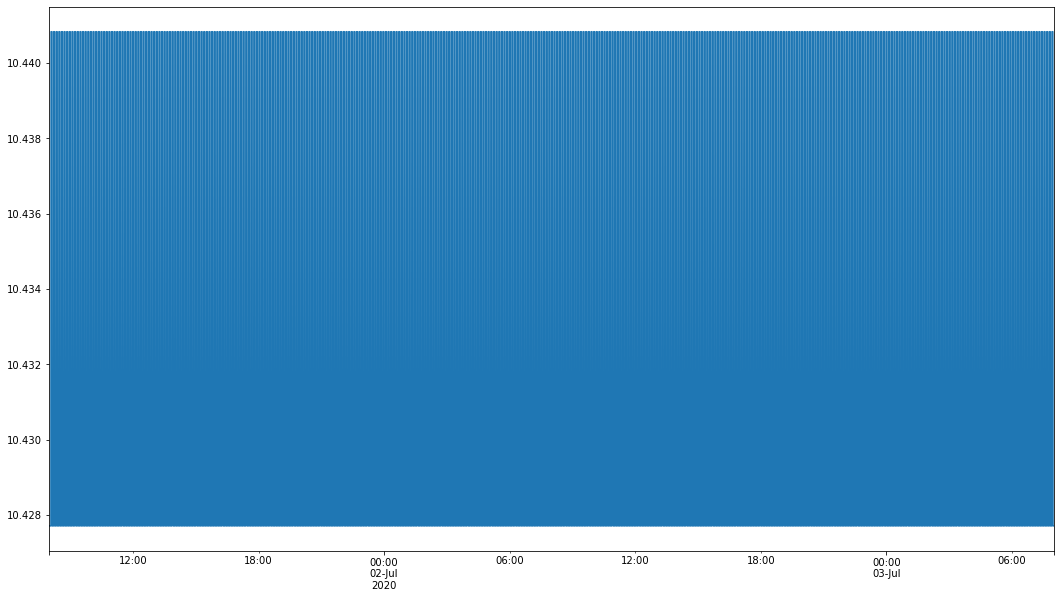

In [420]:
judge.displayFlightAltitudeThroughputInfo(flight)

 Flight Info
86400 Second cycles, for 0 cycles with 0 left over
2020-07-02 00:00:00-04:00
altitude min=1000 mean=3819 max=6640


Graphics3d Object



 Power info
2020-12-03 08:00:00-05:00
mSoc = 16.58%




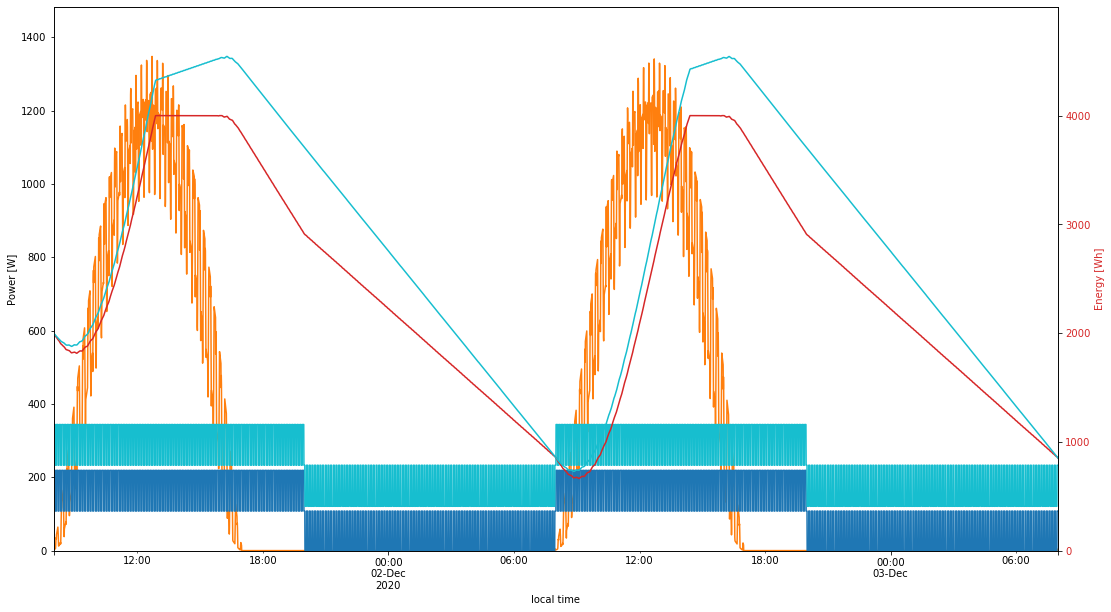

In [562]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import SimpleLadderTrajectory
base_height = 1000

trajectory = SimpleLadderTrajectory(
    (0, 0, base_height),
    lobeRadius = 500,
    lobeCenterDistance = 1495.6,
    stepHeight=60,
    nSteps=47
)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight, threed=True)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-12-01T08', end = '2020-12-03T08')

 Throughput (estimated) and altitude
2020-07-03 08:00:00-04:00


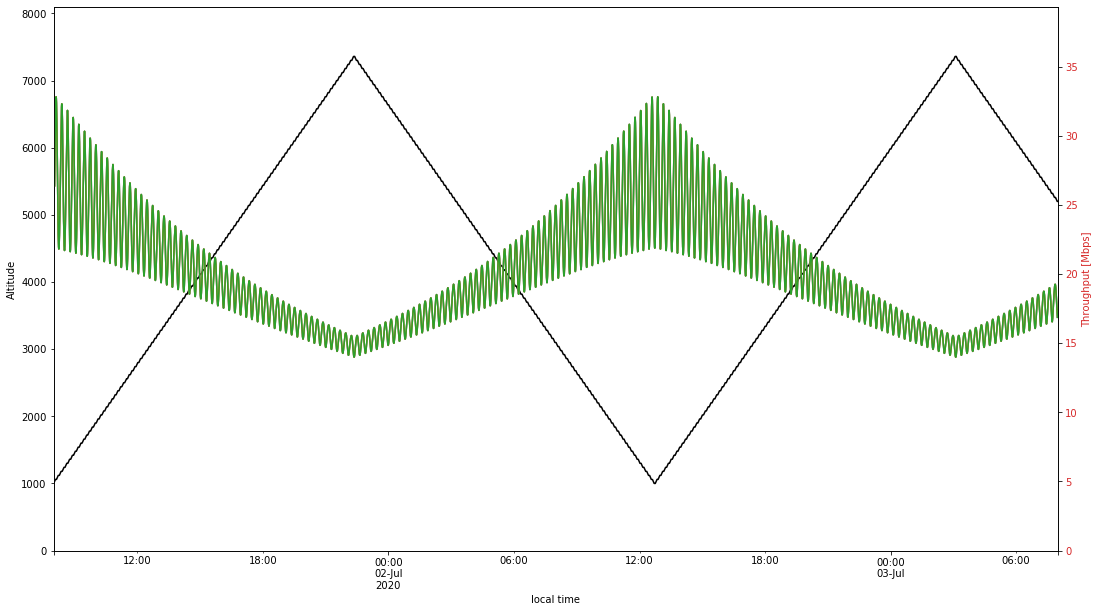

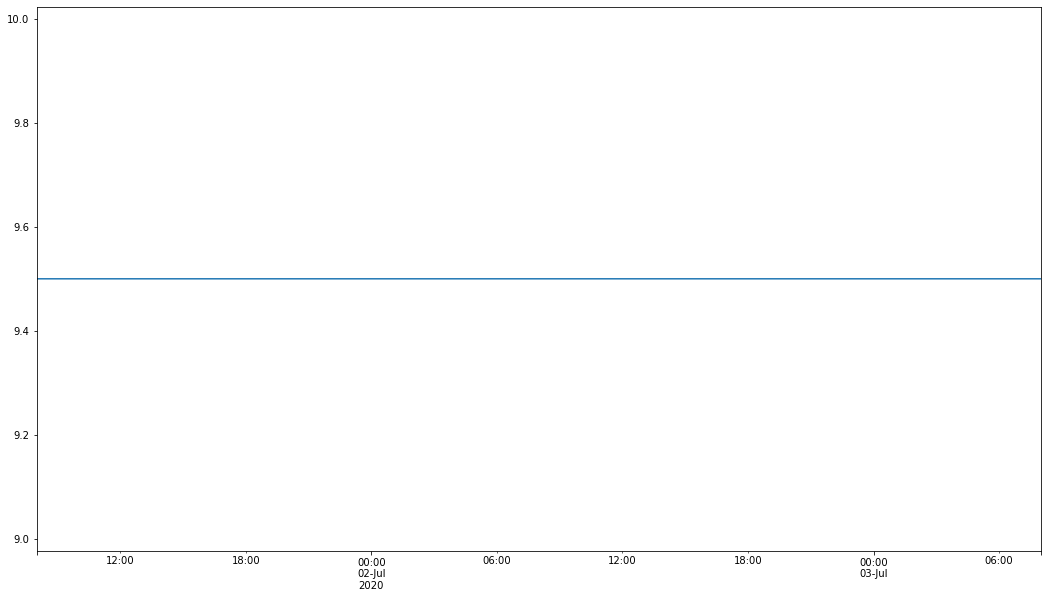

In [428]:
judge.displayFlightAltitudeThroughputInfo(flight)

0.11134101434096388
 Flight Info
3079 Second cycles, for 28 cycles with 177 left over
2020-07-01 00:51:00-04:00
altitude min=1000 mean=1000 max=1000


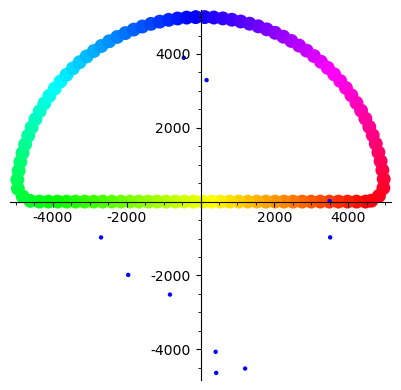



 Power info
2020-12-03 08:00:00-05:00
mSoc = 0.77%




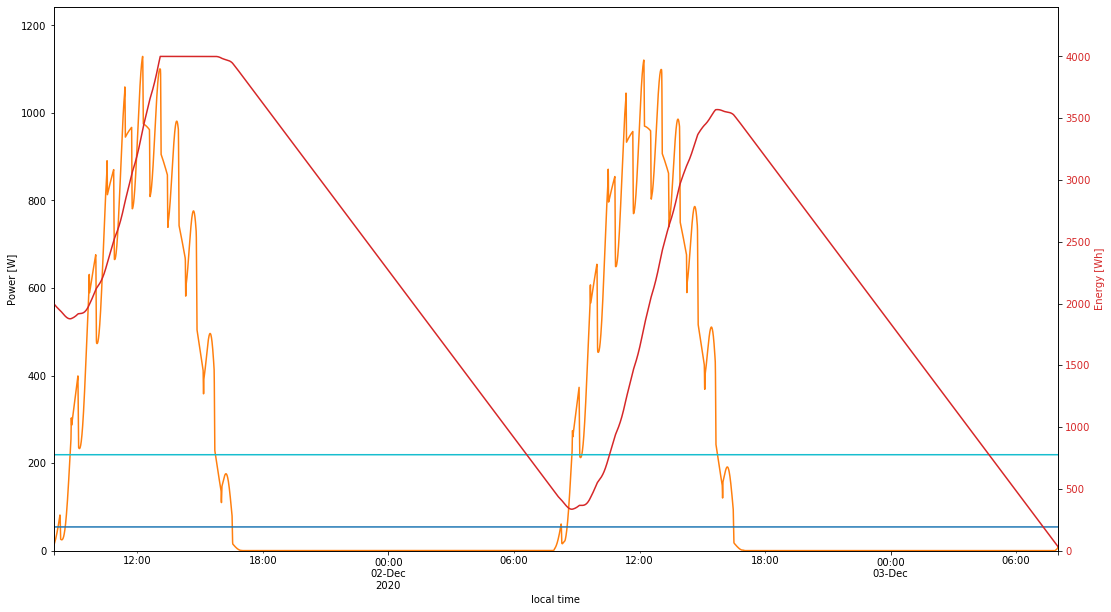

In [536]:
if 'thesis.Trajectory' in sys.modules: del sys.modules['thesis.Trajectory']
from thesis.Trajectory import DTrajectory

trajectory = DTrajectory((0, 0, 1000), 5000, 500, 0, False)
flight = Flight(craft, trajectory, [5 for piece in trajectory.pieces], **radioParams)

judge.displayFlightTrajectoryInfo(flight)
judge.displayFlightPower(flight, bat_Wh_cap, P_payload, start = '2020-12-01T08', end = '2020-12-03T08')